# Estimating COVID-19's $R_t$ in Real-Time for EU - results

Data and estimates from April 23. See the `Realtime R0` notebook for how numbers here were derived.

In [31]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

COUNTRIES_INCLUDED = sorted(['Austria', 'Italy', 'Belgium', 'Latvia', 'Bulgaria', 'Lithuania', 'Croatia', 'Luxembourg', 
                      'Cyprus', 'Malta', 'Czechia', 'Netherlands', 'Denmark', 'Poland', 'Estonia', 'Portugal', 
                      'Finland', 'Romania', 'France', 'Slovakia', 'Germany', 'Slovenia', 'Greece', 'Spain', 
                      'Hungary', 'Sweden', 'Ireland', 'Russia', 'Norway', 'Switzerland'])

%config InlineBackend.figure_format = 'retina'

In [2]:
def plot_rt(result, ax, country_name, scatter_alpha=1.0):
    
    ax.set_title(f"{country_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               alpha=scatter_alpha,
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 2.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

In [39]:
final_results = pd.read_csv('data/rt_pymc3.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['country', 'date'],
                            squeeze=True)

In [40]:
# TODO: fix column names in the MCMC notebook
final_results.columns = ['mean', 'ML', 'Low_90', 'High_90', 'Low_50', 'High_50']
final_results.index.names = ['country', 'date']

In [41]:
final_results

mean        ML    Low_90   High_90    Low_50   High_50
country date                                                                  
France  2020-01-23  1.676230  1.659259  1.253383  2.083502  1.496649  1.841672
        2020-01-24  1.679147  1.664283  1.274733  2.093324  1.408814  1.749580
        2020-01-25  1.680840  1.664366  1.291923  2.097854  1.438095  1.774048
        2020-01-26  1.685776  1.671595  1.312293  2.105268  1.509404  1.842075
        2020-01-27  1.689811  1.674230  1.316204  2.095031  1.481474  1.810684
...                      ...       ...       ...       ...       ...       ...
Poland  2020-05-19  1.075947  1.073001  0.891134  1.261099  1.002009  1.143723
        2020-05-20  1.075712  1.074804  0.878157  1.269534  1.008471  1.154015
        2020-05-21  1.075099  1.073226  0.862890  1.275182  1.001129  1.157867
        2020-05-22  1.075461  1.075268  0.872637  1.317031  0.984979  1.155663
        2020-05-23  1.075666  1.077563  0.854973  1.313882  1.000816  1.177899

[351 rows x 6 columns]

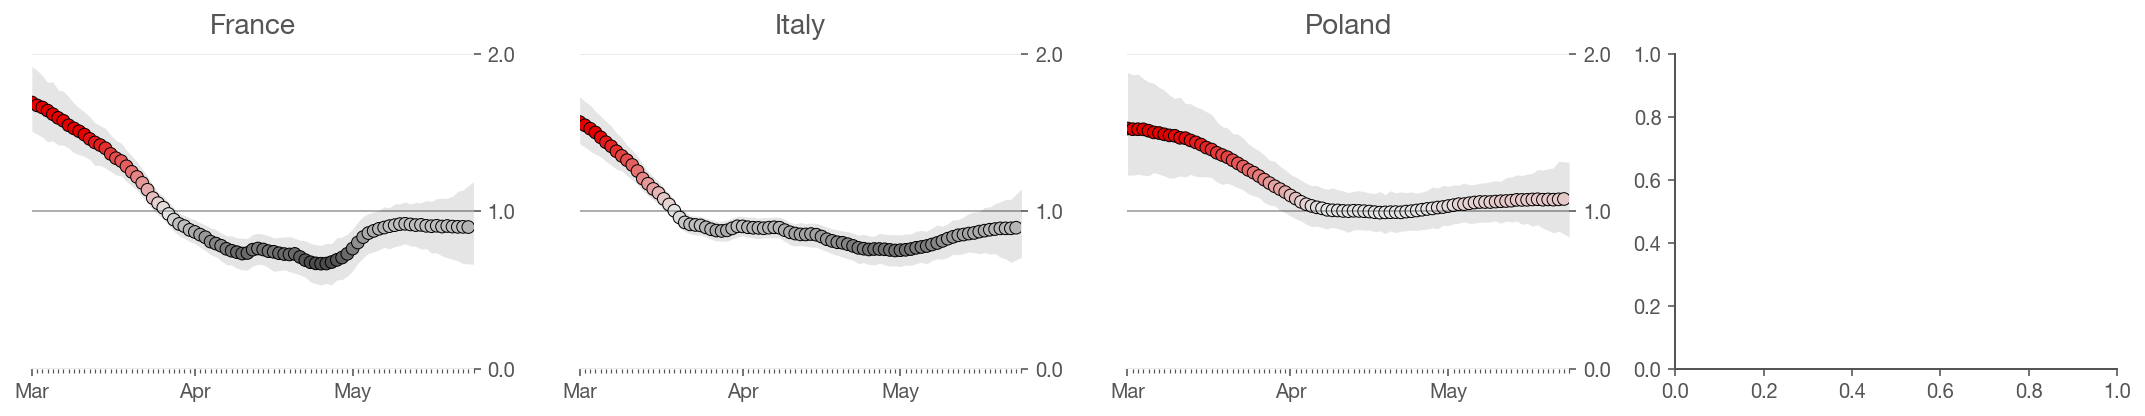

In [42]:
ncountries = len(final_results.index.unique(level='country'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results.groupby('country')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)

fig.tight_layout()
fig.set_facecolor('w')

## Standings

In [43]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [44]:
no_lockdown = []
partial_lockdown = []

In [45]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Country'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)
    
    too_uncertain = mr.index[(mr['High_90'] - mr['Low_90']) > 1.2]

    for bar, country_name in zip(bars, mr.index):
        if country_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if country_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)
        if country_name in too_uncertain:
            bar.set_alpha(0.3)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)
    
    if not too_uncertain.empty:
        leg = ax.legend(handles=[
                    Patch(label='Insufficient data or an end of epidemy', color=FULL_COLOR, alpha=0.3),
                ],
#                 title='Lockdown',
#                 ncol=3,
                loc='upper left',
                columnspacing=.75,
                handletextpad=.5,
                handlelength=1)
        leg._legend_box.align = "left"

        
    fig.set_facecolor('w')
    return fig, ax

               ML   High_90    Low_90
country                              
France   0.899239  1.161533  0.665415
Italy    0.895065  1.108208  0.690969
Poland   1.077563  1.313882  0.854973


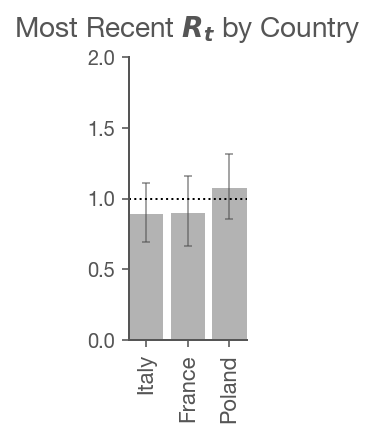

In [53]:
targets = final_results.index.get_level_values('country').isin(COUNTRIES_INCLUDED)
mr = final_results.loc[targets].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

print(mr)

mr.sort_values('ML', inplace=True)
fig, ax = plot_standings(mr)

# Rainier

In [54]:
final_results_rainier = pd.read_csv('data/rt-rainier.csv',
                            parse_dates=['date'],infer_datetime_format=True,
                            index_col=['country', 'date'],
                            squeeze=True)

In [55]:
final_results_rainier

ML    Low_90   High_90
country        date                                    
Austria        2020-02-06  1.642537  1.172173  2.088173
               2020-02-07  1.645237  1.176439  2.070291
               2020-02-08  1.654373  1.177196  2.076442
               2020-02-09  1.659138  1.162128  2.064254
               2020-02-10  1.672299  1.255511  2.147736
...                             ...       ...       ...
United_Kingdom 2020-05-19  0.977585  0.847317  1.100884
               2020-05-20  0.978733  0.826488  1.146731
               2020-05-21  0.980046  0.820621  1.103952
               2020-05-22  0.994216  0.816244  1.159671
               2020-05-23  0.997489  0.837150  1.185616

[3313 rows x 3 columns]

In [56]:
final_results_rainier.columns = ['ML', 'Low_90', 'High_90']

In [57]:
final_results_rainier

ML    Low_90   High_90
country        date                                    
Austria        2020-02-06  1.642537  1.172173  2.088173
               2020-02-07  1.645237  1.176439  2.070291
               2020-02-08  1.654373  1.177196  2.076442
               2020-02-09  1.659138  1.162128  2.064254
               2020-02-10  1.672299  1.255511  2.147736
...                             ...       ...       ...
United_Kingdom 2020-05-19  0.977585  0.847317  1.100884
               2020-05-20  0.978733  0.826488  1.146731
               2020-05-21  0.980046  0.820621  1.103952
               2020-05-22  0.994216  0.816244  1.159671
               2020-05-23  0.997489  0.837150  1.185616

[3313 rows x 3 columns]

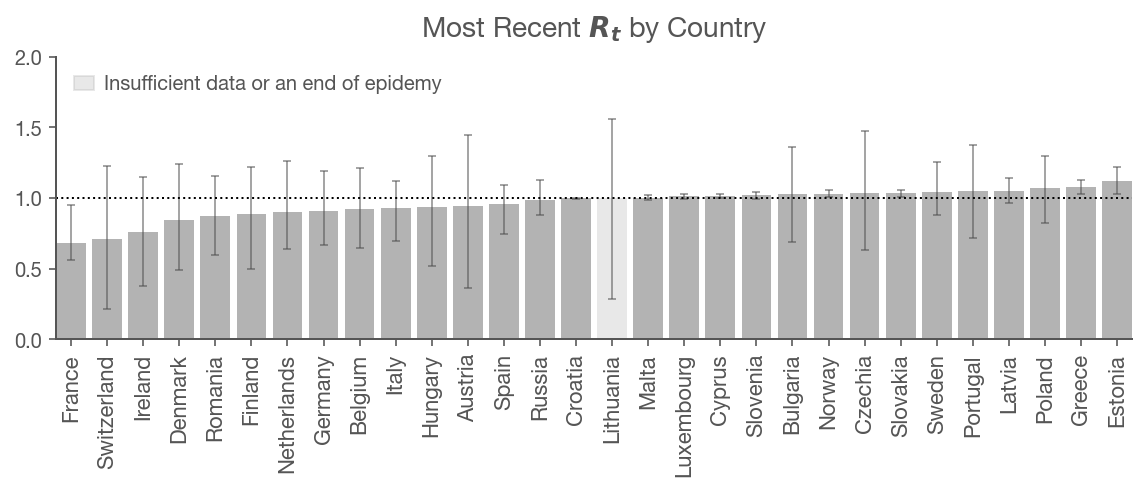

In [58]:
targets_rainier = final_results_rainier.index.get_level_values('country').isin(COUNTRIES_INCLUDED)
mr_rainier = final_results_rainier.loc[targets_rainier].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

mr_rainier.sort_values('ML', inplace=True)
fig, ax = plot_standings(mr_rainier)

## Compare PYMC3's and Rainier's estimates for European countries

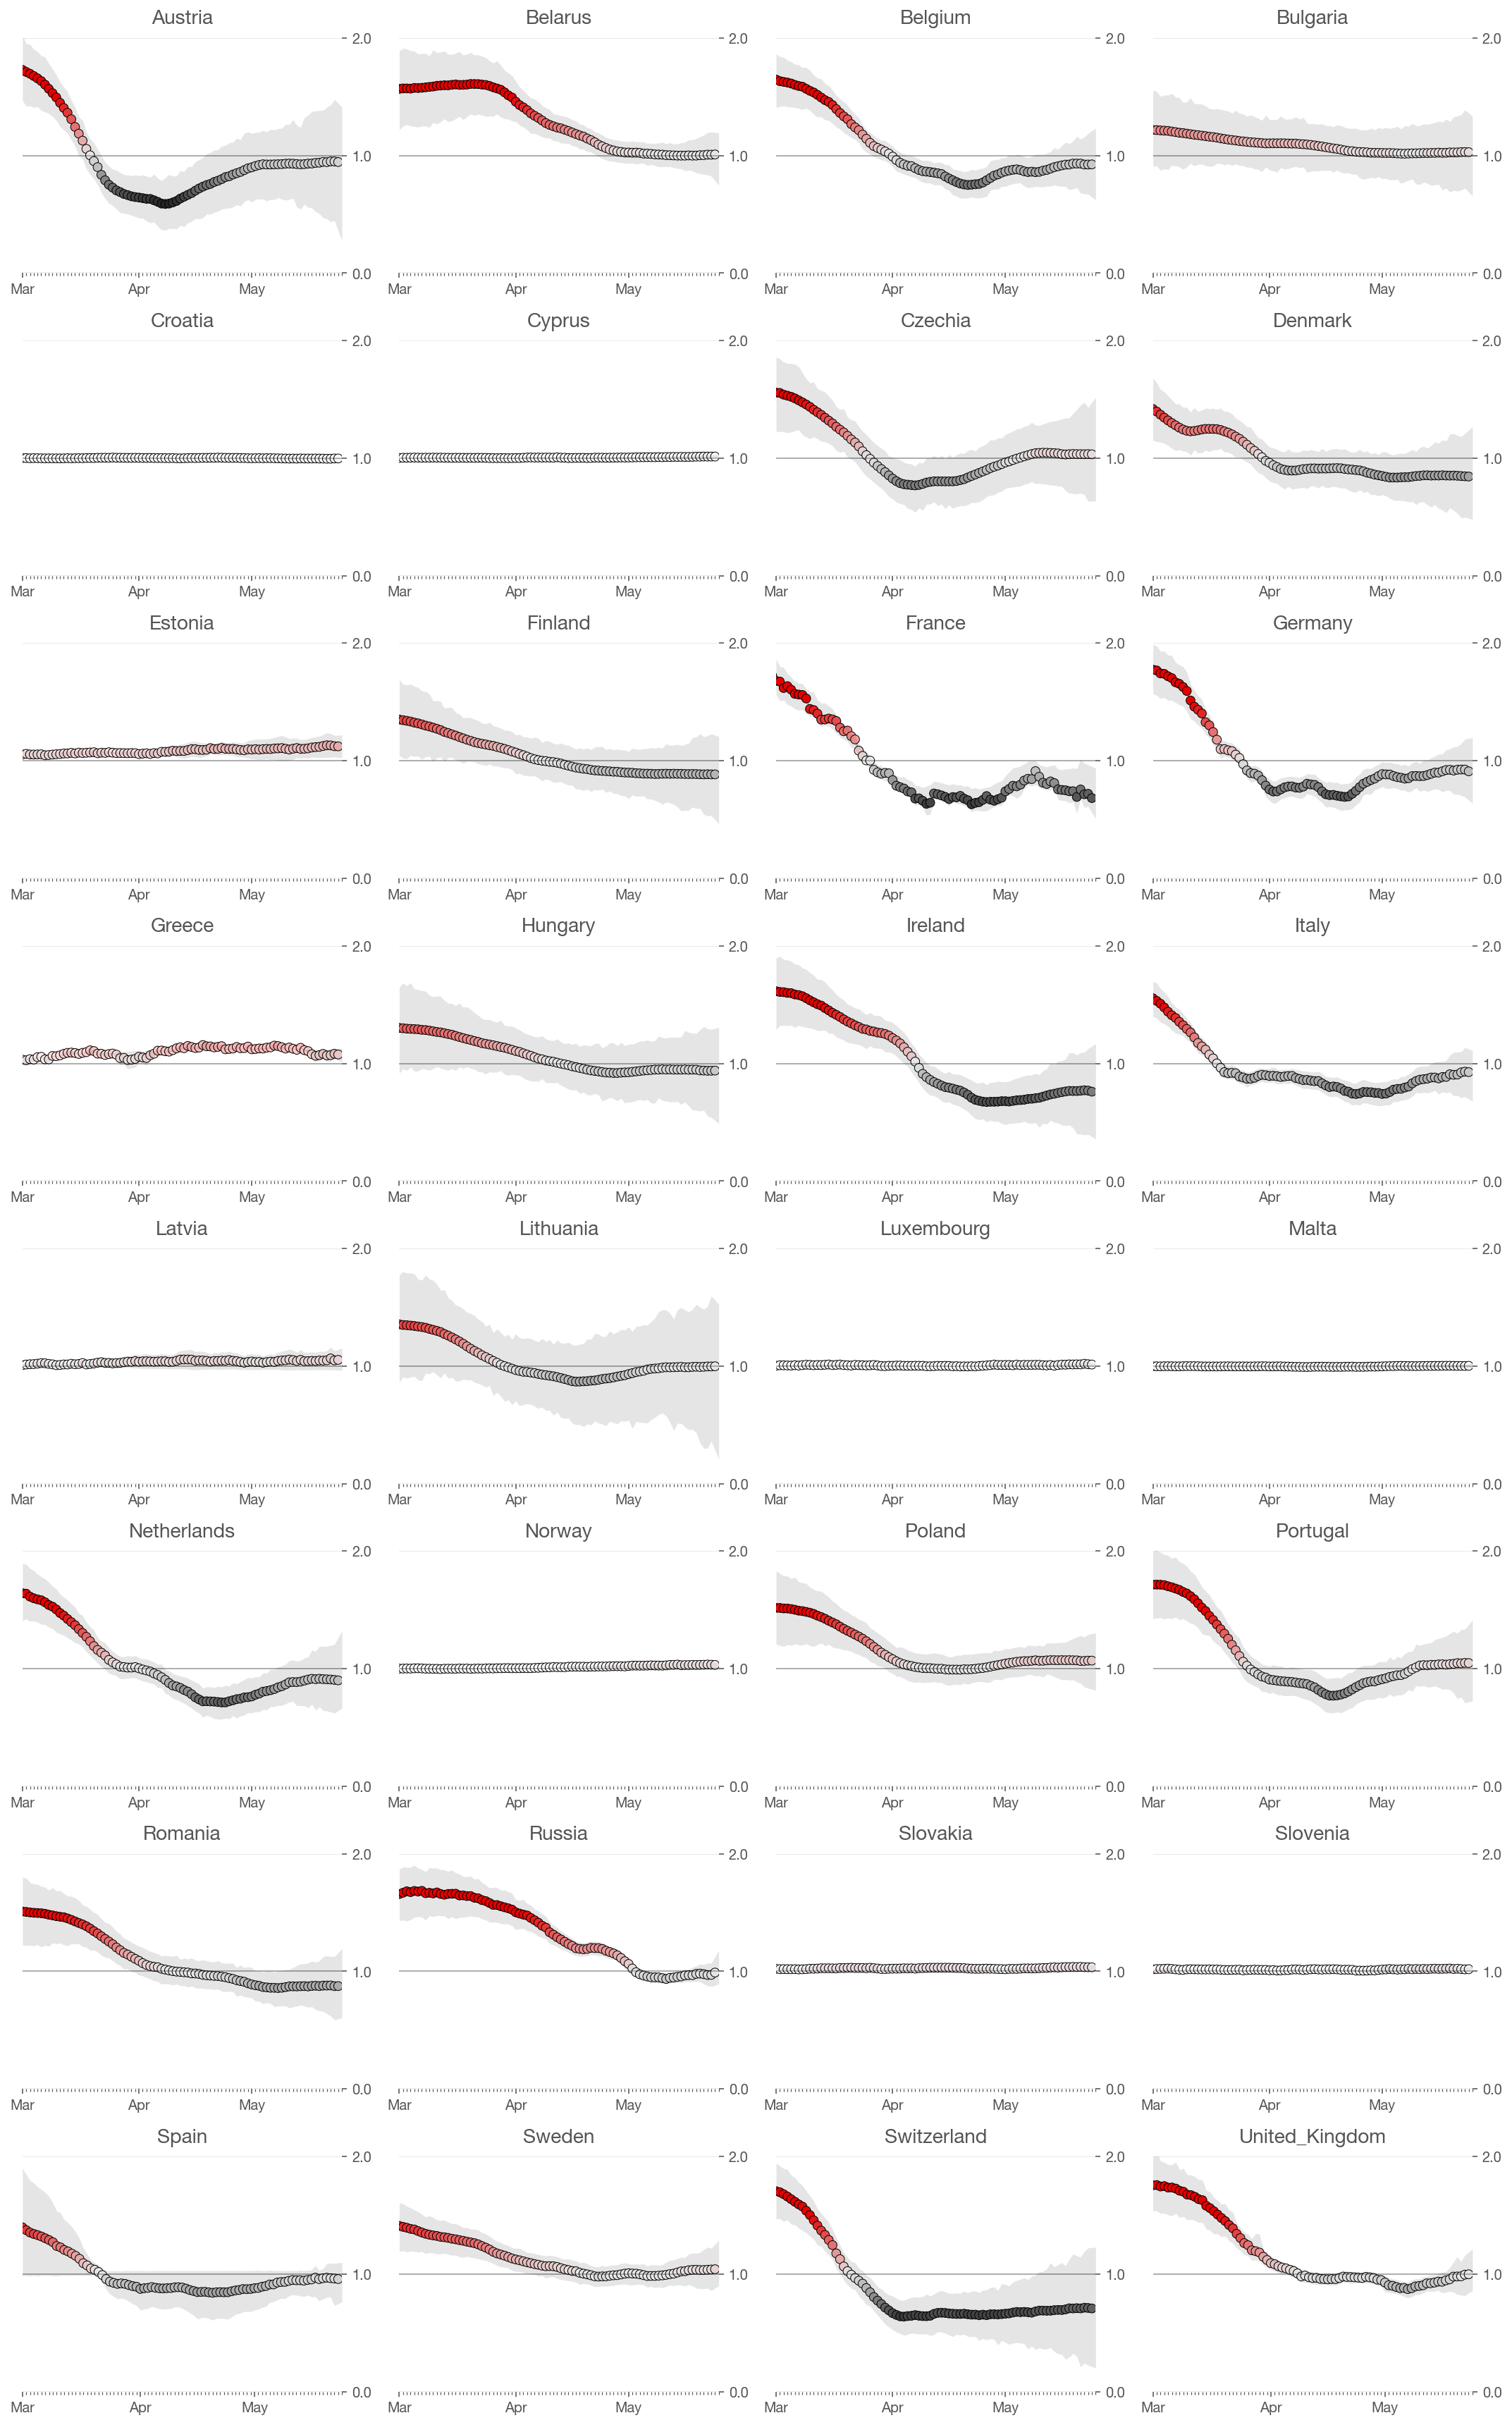

In [59]:
ncountries = len(final_results_rainier.index.unique(level='country'))
ncols = 4
nrows = int(np.ceil(ncountries / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (country_name, result) in enumerate(final_results_rainier.groupby('country')):
    plot_rt(result.iloc[1:], axes.flat[i], country_name)
    
#for i, (country_name, result) in enumerate(final_results.groupby('country')):
#    plot_rt(result.iloc[1:], axes.flat[i], country_name, scatter_alpha=0.25)

fig.tight_layout()
fig.set_facecolor('w')